In [2]:
#%pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix
from sklearn.svm import SVC

## 1. Anàlisi exploratori de dades (EDA)

In [3]:
# Configuració visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Càrrega de dades
# Assegura't que el fitxer 'trs_train.csv' està al mateix directori
df = pd.read_csv('trs_train.csv')

print(f"Dimensions del dataset: {df.shape}")
display(df.head())

Dimensions del dataset: (9000, 28)


,patient_id,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,...,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS
0,1,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,...,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133,0
1,2,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,...,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502,0
2,3,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,...,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842,0
3,4,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,...,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249,0
4,5,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,...,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533,0


Taula amb les estadístiques descriptives de les variables numèriques i categòriques del dataset.

In [4]:
stats_desc = df.describe(include='all').T
stats_desc['missing_rate'] = df.isnull().mean()
display(stats_desc)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing_rate
patient_id,9000.0,NaN,NaN,NaN,4500.5,2598.220545,1.0,2250.75,4500.5,6750.25,9000.0,0.000000
Age,9000.0,NaN,NaN,NaN,26.039444,10.011767,13.0,19.0,25.0,31.0,64.0,0.000000
Sex,9000.0,NaN,NaN,NaN,0.576,0.494218,0.0,0.0,1.0,1.0,1.0,0.000000
Ethnicity,9000,4,Caucasian,5408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
Duration_untreated_psychosis,8872.0,NaN,NaN,NaN,19.220548,19.545745,0.3,6.4,12.5,24.3,125.0,0.014222
Family_history,9000.0,NaN,NaN,NaN,0.118778,0.323545,0.0,0.0,0.0,0.0,1.0,0.000000
Initial_response,9000.0,NaN,NaN,NaN,41.840367,30.16023,0.0,10.1,38.2,72.3,100.0,0.000000
Lymphocyte_count,7009.0,NaN,NaN,NaN,1.795761,0.601099,0.5,1.38,1.8,2.2,4.02,0.221222
Neutrophil_count,7015.0,NaN,NaN,NaN,5.014574,1.471581,1.5,4.005,5.02,6.01,9.96,0.220556
BMI,9000.0,NaN,NaN,NaN,28.107556,5.4331,15.0,24.4,28.0,31.7,49.6,0.000000


Desbalanceig de la classe objectiu

Ratio de classes:
TRS
0    0.684667
1    0.315333
Name: proportion, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_18276\2760328015.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TRS', data=df, palette='viridis')


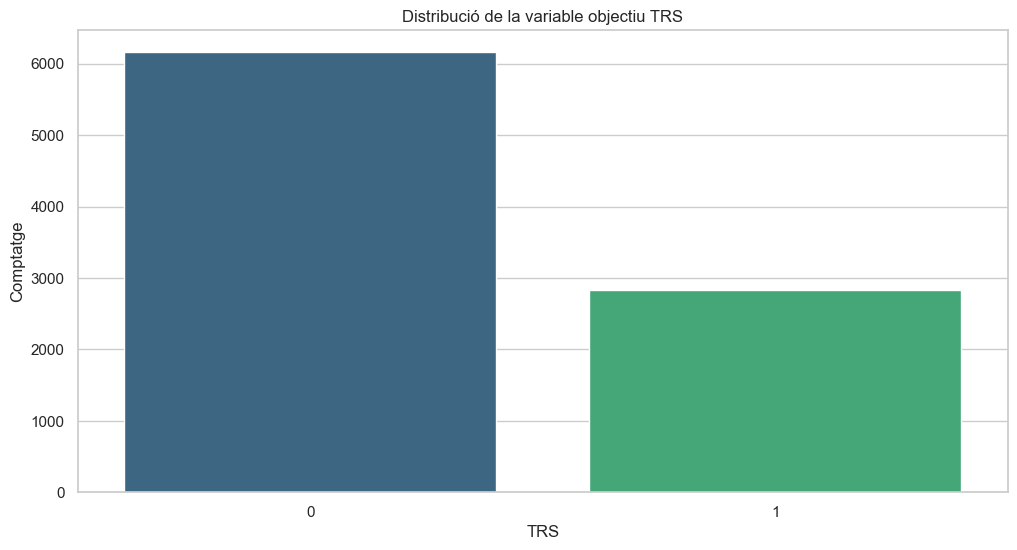

In [5]:
ratio_trs = df['TRS'].value_counts(normalize=True)
print(f"Ratio de classes:\n{ratio_trs}")
plt.figure()
sns.countplot(x='TRS', data=df, palette='viridis')
plt.title('Distribució de la variable objectiu TRS')
plt.xlabel('TRS')
plt.ylabel('Comptatge')
plt.show()

Anàlisi de les variables categòriques en funció de la classe objectiu

Variables categòriques detectades (9):
['Family_history', 'HLA_DRB1_04_02', 'Del_22q11_2_status', 'CYP2D6_metabolic_phenotype', 'Ethnicity', 'HLA_B_15_02', 'Prior_antipsychotics', 'Sex', 'HLA_A_31_01']


VARIABLE                            | P-VALUE    | SIGNIFICATIU?
----------------------------------------------------------------------
Family_history                      | 0.00000    | SÍ !!!


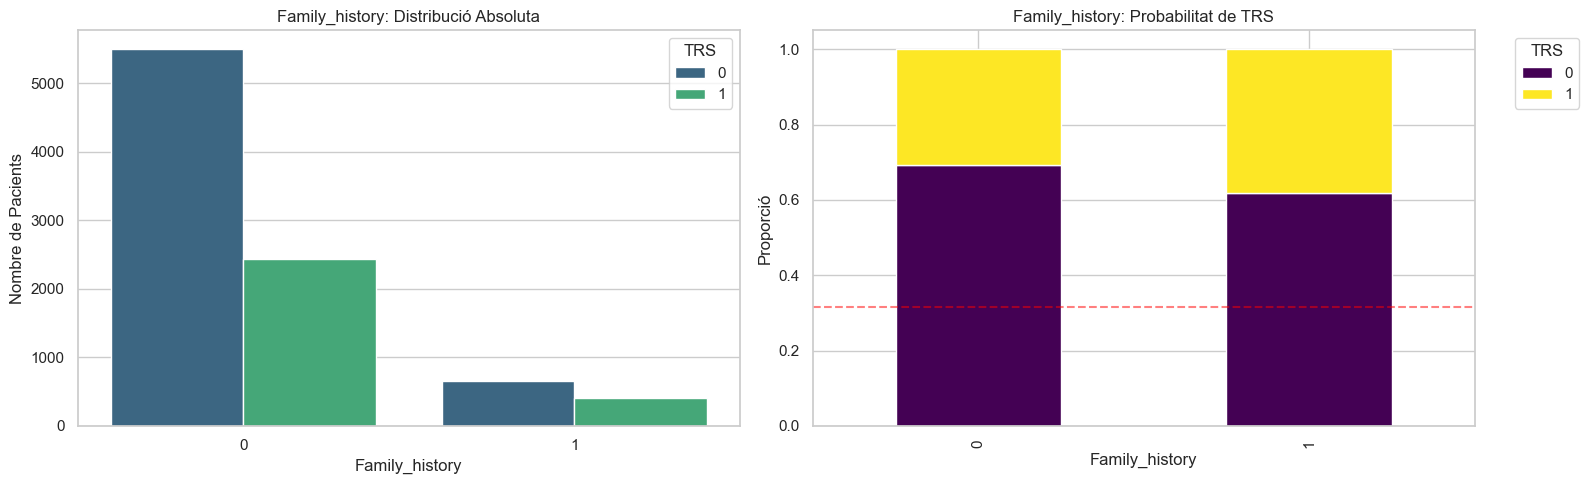

--------------------------------------------------------------------------------
HLA_DRB1_04_02                      | 0.25234    | No


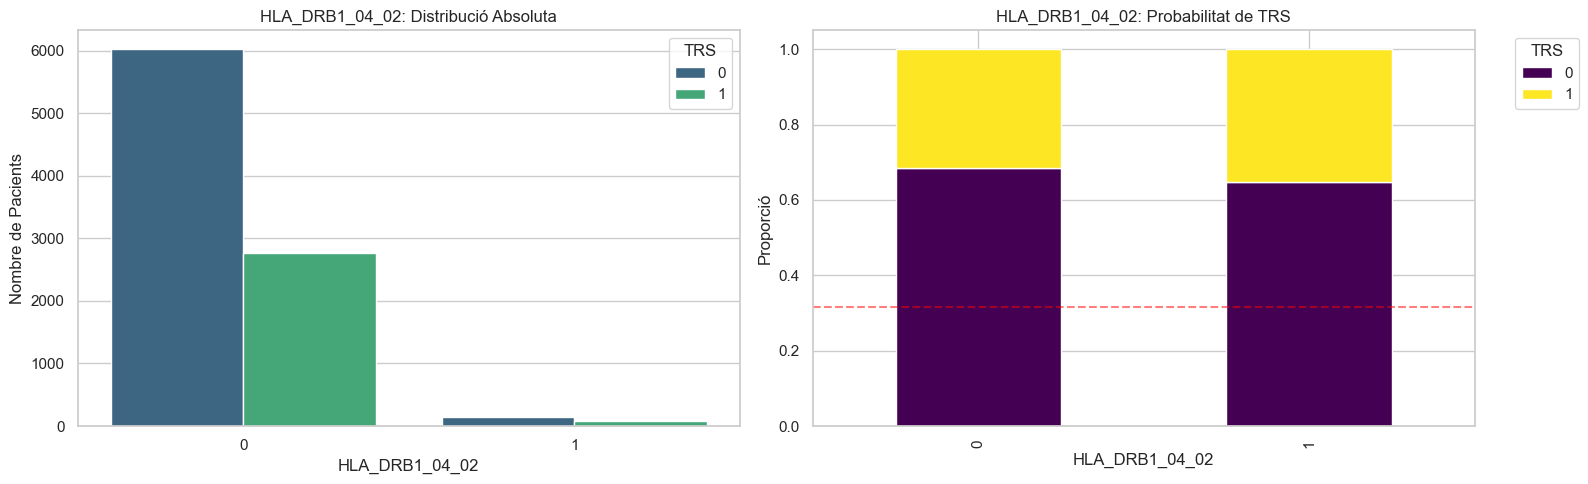

--------------------------------------------------------------------------------
Del_22q11_2_status                  | 0.28333    | No


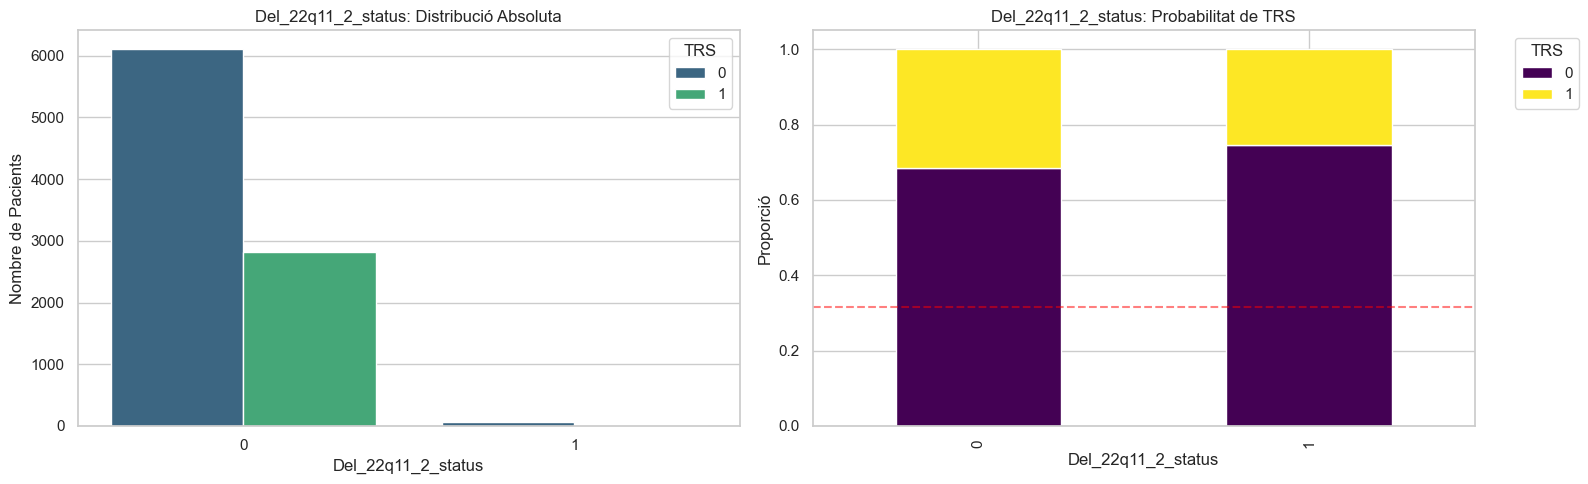

--------------------------------------------------------------------------------
CYP2D6_metabolic_phenotype          | 0.06814    | No


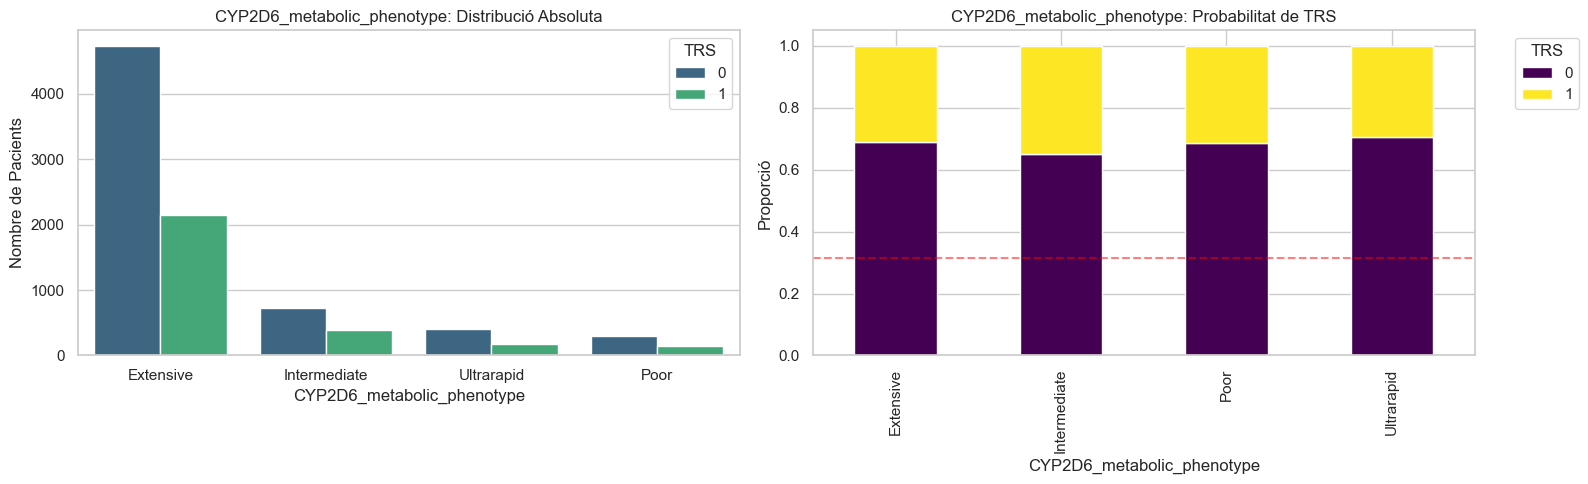

--------------------------------------------------------------------------------
Ethnicity                           | 0.87647    | No


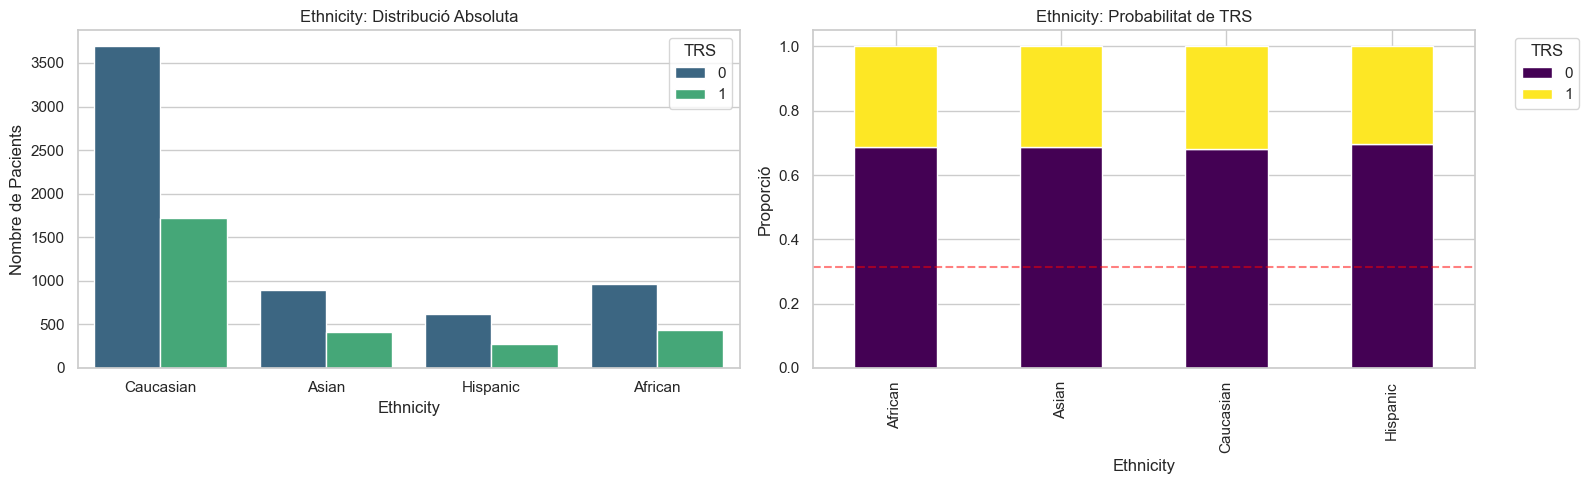

--------------------------------------------------------------------------------
HLA_B_15_02                         | 0.30161    | No


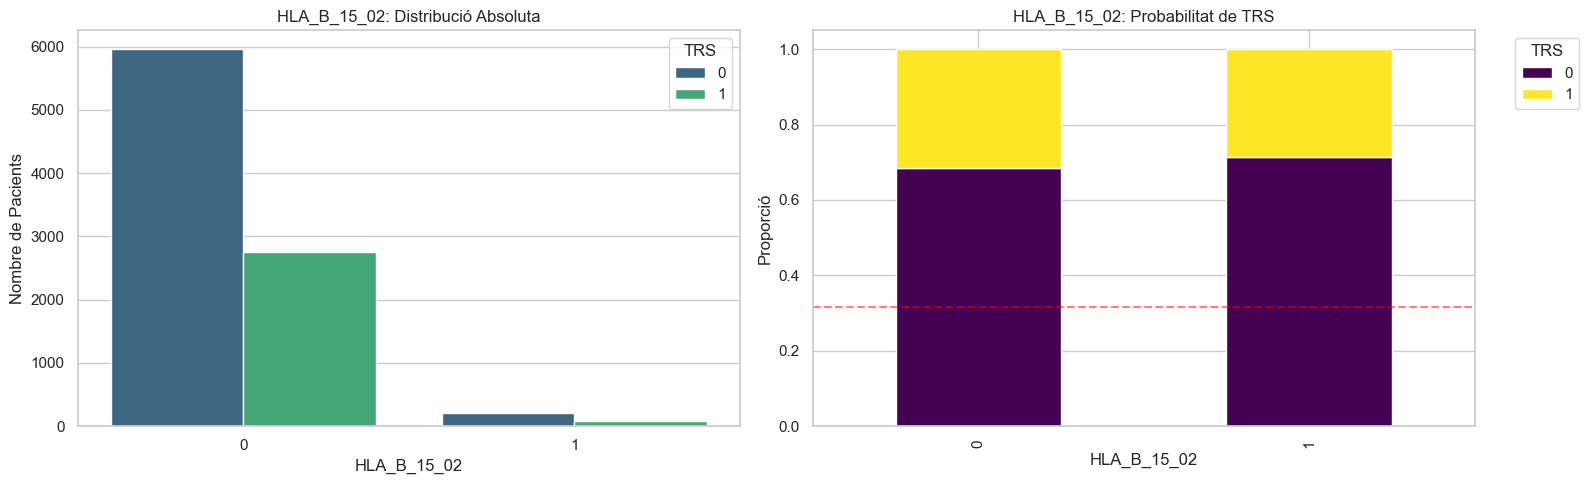

--------------------------------------------------------------------------------
Prior_antipsychotics                | 0.49976    | No


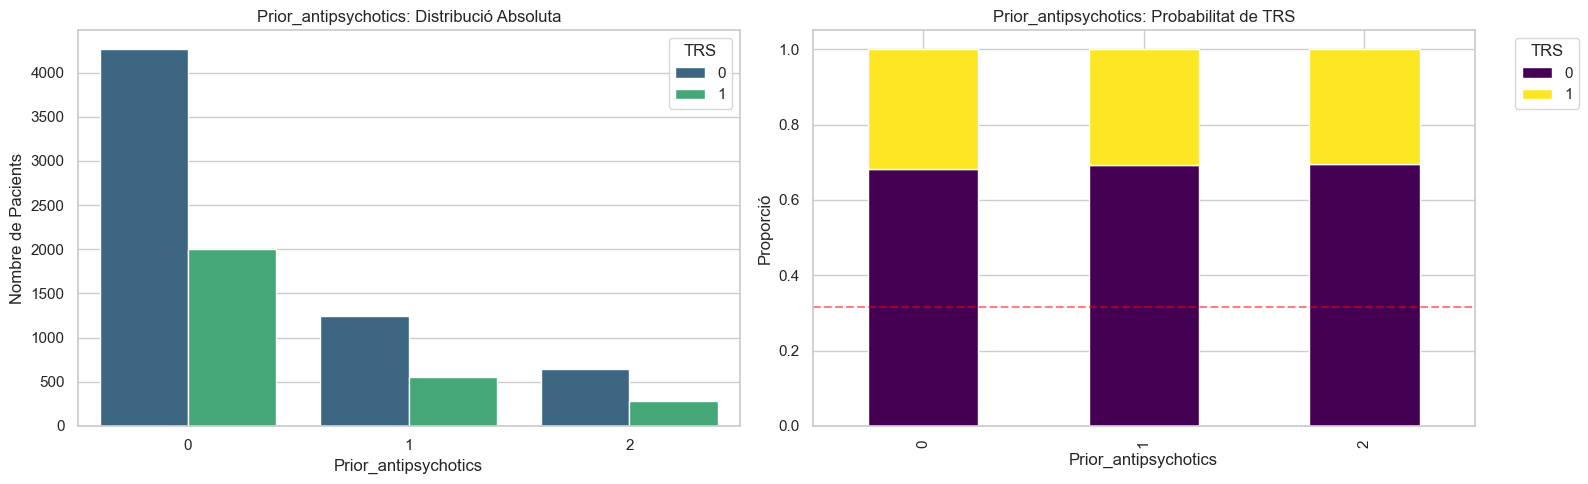

--------------------------------------------------------------------------------
Sex                                 | 0.48567    | No


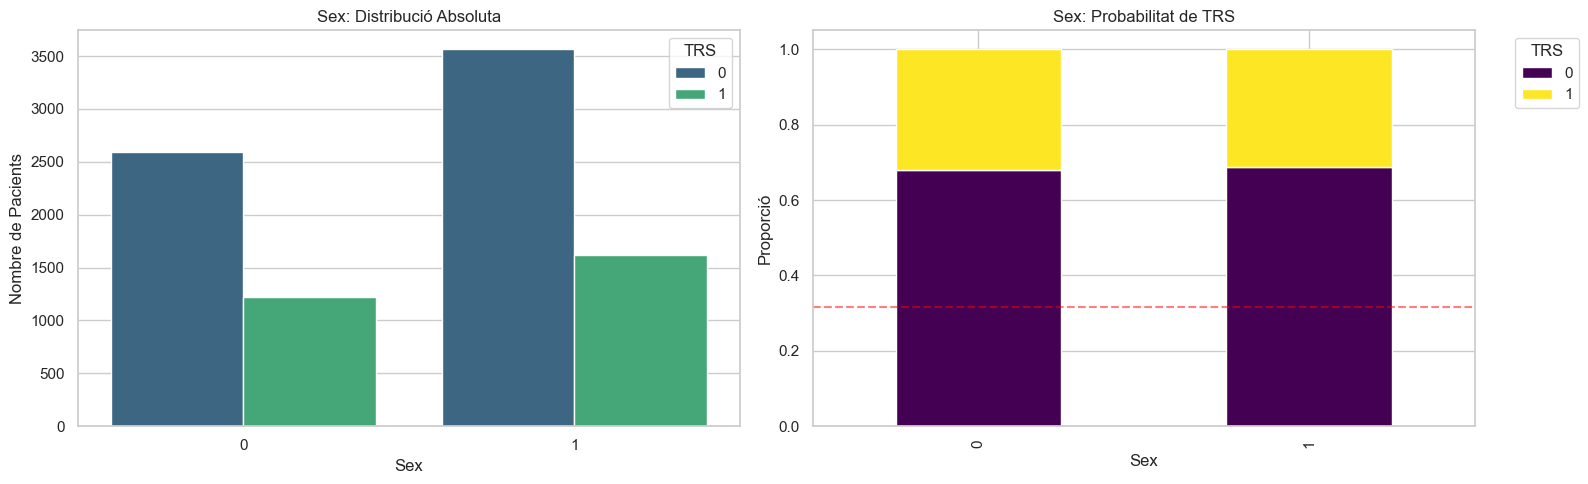

--------------------------------------------------------------------------------
HLA_A_31_01                         | 1.00000    | No


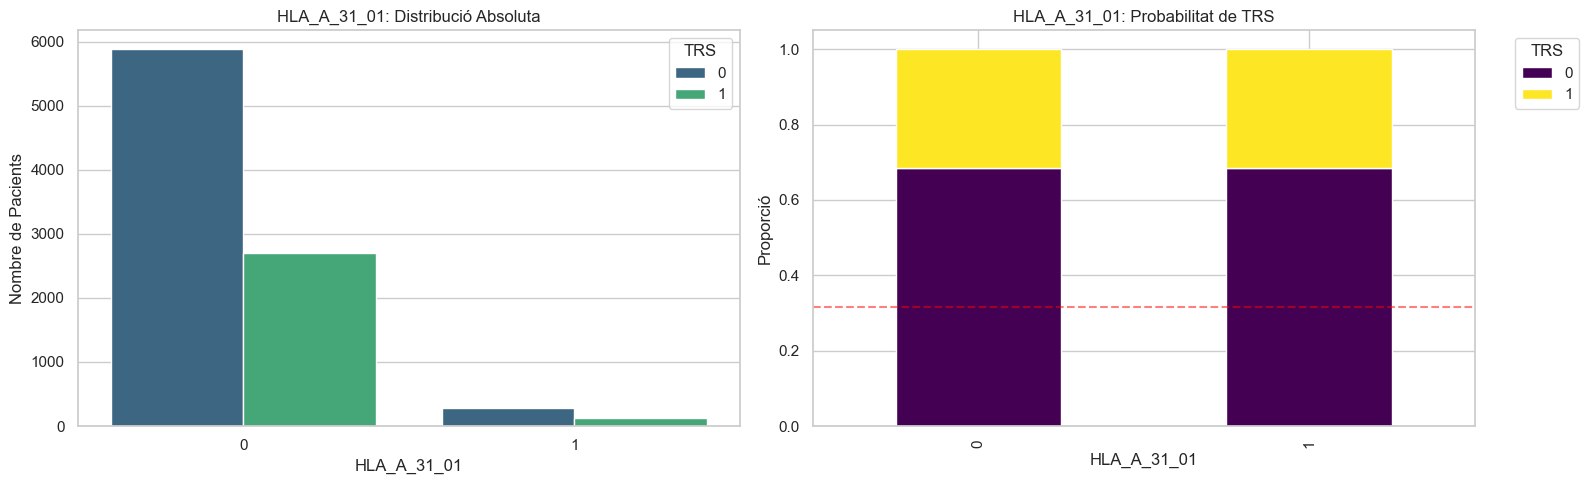

--------------------------------------------------------------------------------


In [6]:

from scipy.stats import chi2_contingency

# 1. Carregar dades
df = pd.read_csv('trs_train.csv')

# 2. DETECCIÓ AUTOMÀTICA DE VARIABLES CATEGÒRIQUES
# ------------------------------------------------
# A. Variables de tipus text (String/Object)
text_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# B. Variables numèriques amb pocs valors únics (ex: Binàries 0/1, o categories numèriques)
# Considerem "categòrica" qualsevol numèrica amb menys de 10 valors únics
num_cols = df.select_dtypes(include=['number']).columns
discrete_num_cols = [col for col in num_cols if df[col].nunique() < 10]

# C. Unim les llistes i netegem
all_categorical_cols = list(set(text_cols + discrete_num_cols))

# D. Eliminem 'TRS' (target) i 'patient_id' (identificador) si hi són
if 'TRS' in all_categorical_cols: all_categorical_cols.remove('TRS')
if 'patient_id' in all_categorical_cols: all_categorical_cols.remove('patient_id')

print(f"Variables categòriques detectades ({len(all_categorical_cols)}):")
print(all_categorical_cols)
print("\n" + "="*80 + "\n")

# 3. ANÀLISI I VISUALITZACIÓ
# -------------------------
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

# Capçalera taula resultats
print(f"{'VARIABLE':<35} | {'P-VALUE':<10} | {'SIGNIFICATIU?'}")
print("-" * 70)

for col in all_categorical_cols:
    # --- A. TEST CHI-QUADRAT ---
    contingency_table = pd.crosstab(df[col], df['TRS'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    is_significant = "SÍ !!!" if p_value < 0.05 else "No"
    print(f"{col:<35} | {p_value:.5f}    | {is_significant}")

    # --- B. GRÀFICS ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Gràfic 1: Absolut (Barres normals)
    sns.countplot(data=df, x=col, hue='TRS', ax=axes[0], palette='viridis')
    axes[0].set_title(f'{col}: Distribució Absoluta')
    axes[0].set_ylabel('Nombre de Pacients')
    
    # Gràfic 2: Relatiu (100% Stacked) - EL MÉS IMPORTANT PER VEURE EL RISC
    props = pd.crosstab(df[col], df['TRS'], normalize='index')
    props.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
    
    axes[1].set_title(f'{col}: Probabilitat de TRS')
    axes[1].set_ylabel('Proporció')
    axes[1].legend(title='TRS', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Línia de la mitjana global
    global_mean = df['TRS'].mean()
    axes[1].axhline(y=global_mean, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    print("-" * 80)


Anàlisi de la distribució de les variables numèriques.
Els models són sensibles a distribucions no normals, per tant, volem una mesura de Skewness també.

In [ ]:
from scipy.stats import skew, kurtosis


num_cols = df.select_dtypes(include=['number']).columns
continuous_cols = [col for col in num_cols if df[col].nunique() > 10 and col != 'patient_id']

print(f"Variables contínues detectades ({len(continuous_cols)}):")
print(continuous_cols)
print("\n" + "="*80 + "\n")

# 3. TAULA RESUM DE SKEWNESS I KURTOSIS
skew_data = []
for col in continuous_cols:
    # Eliminem NaNs per al càlcul estadístic
    clean_series = df[col].dropna()
    col_skew = skew(clean_series)
    col_kurt = kurtosis(clean_series)
    
    # Classifiquem la gravetat de l'asimetria
    if abs(col_skew) > 1:
        status = "🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)"
    elif abs(col_skew) > 0.5:
        status = "🟠 MODERADA"
    else:
        status = "🟢 NORMAL (Simètrica)"
        
    skew_data.append({
        'Variable': col,
        'Skewness': col_skew,
        'Kurtosis': col_kurt,
        'Estat': status
    })

skew_df = pd.DataFrame(skew_data).sort_values('Skewness', key=abs, ascending=False)

print("ANÀLISI D'ASIMETRIA (SKEWNESS):")
print("-" * 80)
# Mostrem la taula amb format bonic
print(skew_df.to_string(index=False))
print("-" * 80)
print("Nota: Skewness > 0 significa cua a la dreta. Skewness < 0 significa cua a l'esquerra.")
print("\n" + "="*80 + "\n")

# 4. VISUALITZACIÓ GRÀFICA
sns.set_style("whitegrid")

for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # GRÀFIC 1: Histograma + Densitat (KDE)
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].set_title(f'Distribució: {col}')
    
    # Afegim línies per Mitjana i Mediana
    axes[0].axvline(df[col].mean(), color='red', linestyle='--', label='Mitjana')
    axes[0].axvline(df[col].median(), color='green', linestyle='-', label='Mediana')
    axes[0].legend()

    # GRÀFIC 2: Boxplot (Per veure Outliers)
    sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot (Outliers): {col}')
    
    plt.tight_layout()
    plt.show()


Anàlisi de les correlacions de les variables numèriques per observar linearitat o colinearitat


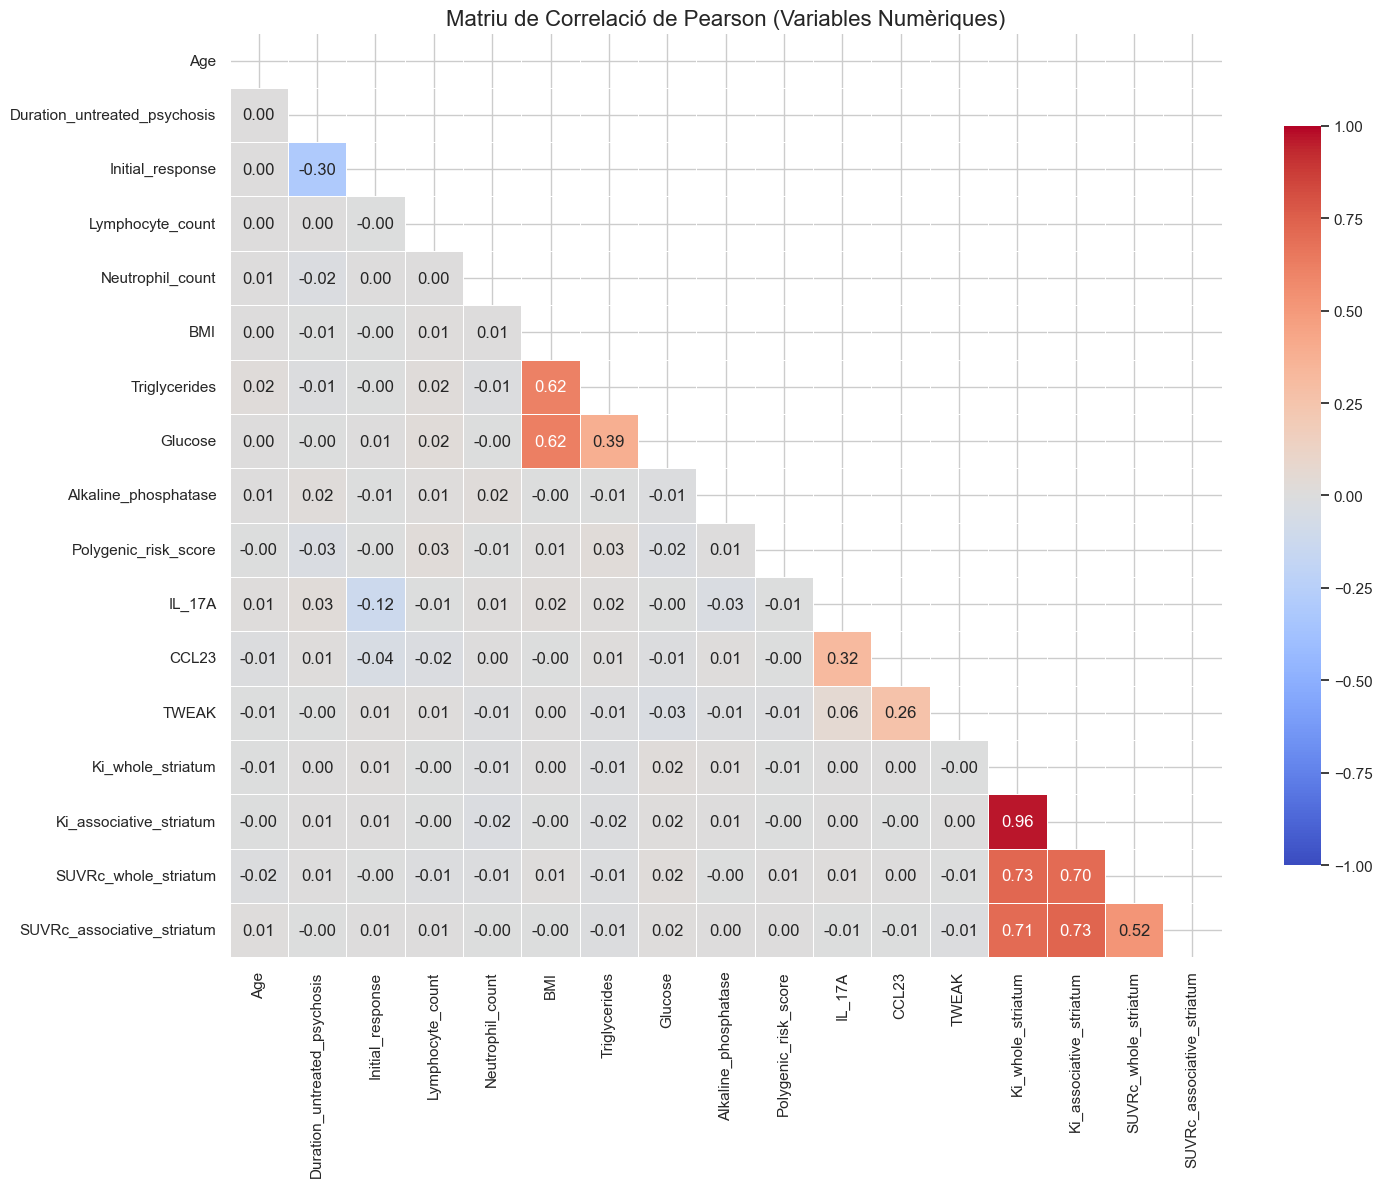


ALERTA DE MULTICOLINEALITAT (Coeficient > 0.7):
------------------------------------------------------------
Ki_associative_striatum        <--> Ki_whole_striatum              : 0.9644
SUVRc_whole_striatum           <--> Ki_whole_striatum              : 0.7265
SUVRc_whole_striatum           <--> Ki_associative_striatum        : 0.7043
SUVRc_associative_striatum     <--> Ki_whole_striatum              : 0.7055
SUVRc_associative_striatum     <--> Ki_associative_striatum        : 0.7336


In [12]:

numerical_cols = df.select_dtypes(include=['number']).columns
# treiem les variables binàries i categòriques codificades numèricament
numerical_cols = [col for col in numerical_cols if df[col].nunique() > 10]
cols_to_analyze = [col for col in numerical_cols if col not in ['patient_id', 'TRS']]

# 3. CALCULAR CORRELACIÓ (Pearson)
corr_matrix = df[cols_to_analyze].corr()

# 4. VISUALITZACIÓ (HEATMAP)
plt.figure(figsize=(16, 12))

# Màscara per amagar la meitat superior (és redundant)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Dibuixar el heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,              # Mostrar números
            fmt=".2f",               # 2 decimals
            cmap='coolwarm',         # Blau-Vermell (Vermell = alta correlació positiva)
            vmax=1, vmin=-1,         # Escala de -1 a 1
            center=0,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Matriu de Correlació de Pearson (Variables Numèriques)', fontsize=16)
plt.show()

# 5. LLISTA DE PARELLS AMB ALTA COLINEALITAT (> 0.7 o < -0.7)
print("\nALERTA DE MULTICOLINEALITAT (Coeficient > 0.7):")
print("-" * 60)

# Recorrem la matriu per trobar valors alts
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            coef = corr_matrix.iloc[i, j]
            print(f"{var1:<30} <--> {var2:<30} : {coef:.4f}")
            high_corr_pairs.append((var1, var2, coef))

if not high_corr_pairs:
    print("No s'han detectat problemes greus de multicolinealitat.")


Anàlisi de valors extrems (outliers)

,variable,n_outliers,pct_outliers
1,Duration_untreated_psychosis,651,7.233333
0,Age,360,4.000000
9,Polygenic_risk_score,125,1.388889
14,Ki_associative_striatum,83,0.922222
13,Ki_whole_striatum,71,0.788889
11,CCL23,59,0.655556
12,TWEAK,58,0.644444
10,IL_17A,57,0.633333
5,BMI,39,0.433333
15,SUVRc_whole_striatum,35,0.388889


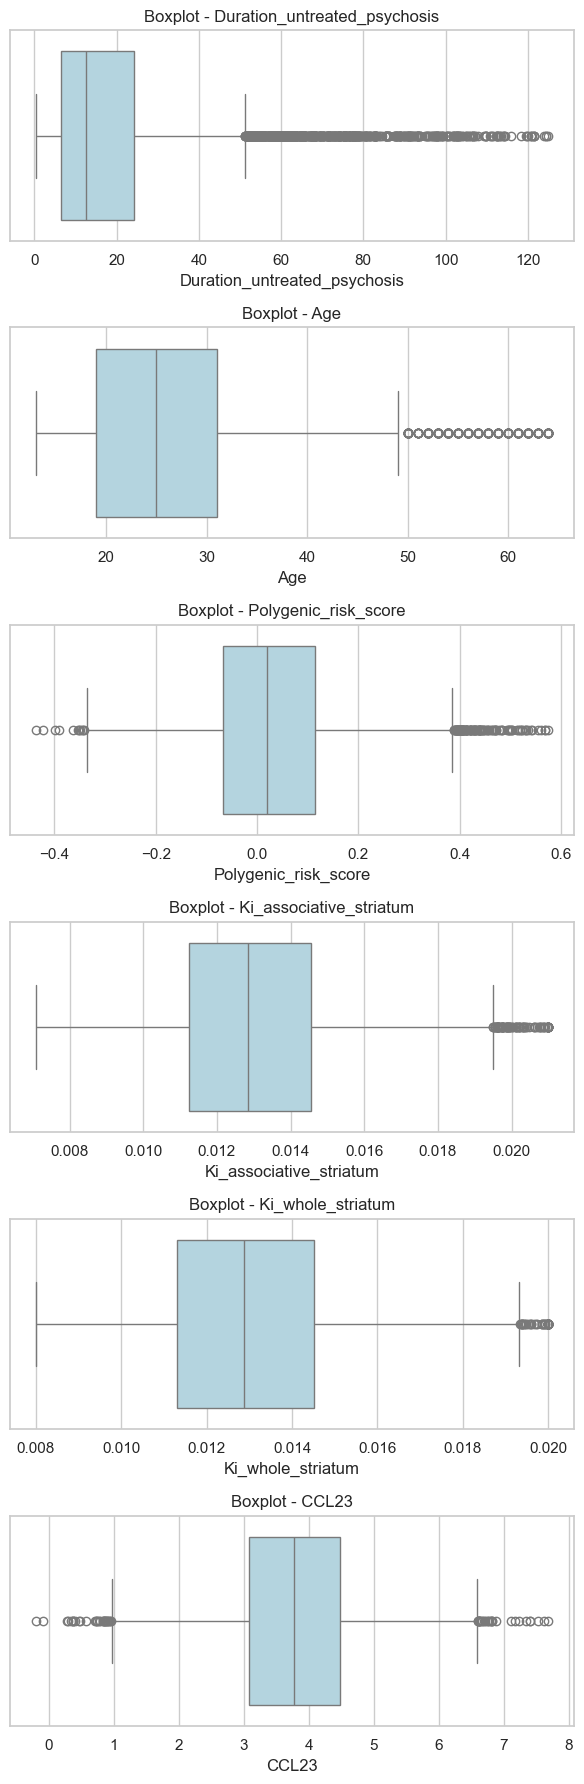

In [9]:
# Detecció d'outliers per a variables numèriques (IQR) i categories rares (<1%) per a categòriques i binàries

# --------------------------
# Numèriques (IQR rule 1.5)
# --------------------------
num_cols = [
    c for c in df.select_dtypes(include='number').columns
    if df[c].nunique() > 10 and c not in ['patient_id']
]

outlier_summary = []
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_summary.append({
        'variable': col,
        'n_outliers': int(mask.sum()),
        'pct_outliers': mask.mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('pct_outliers', ascending=False)
display(outlier_df)

# Boxplots de les variables amb més outliers (top 6)
top_cols = outlier_df.head(6)['variable']
if len(top_cols) > 0:
    fig, axes = plt.subplots(len(top_cols), 1, figsize=(6, 3 * len(top_cols)))
    if len(top_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, top_cols):
        sns.boxplot(x=df[col], ax=ax, color='lightblue')
        ax.set_title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()

Anàlisi de les components principals. Fem una imputació perquè PCA no tolera NaNs.

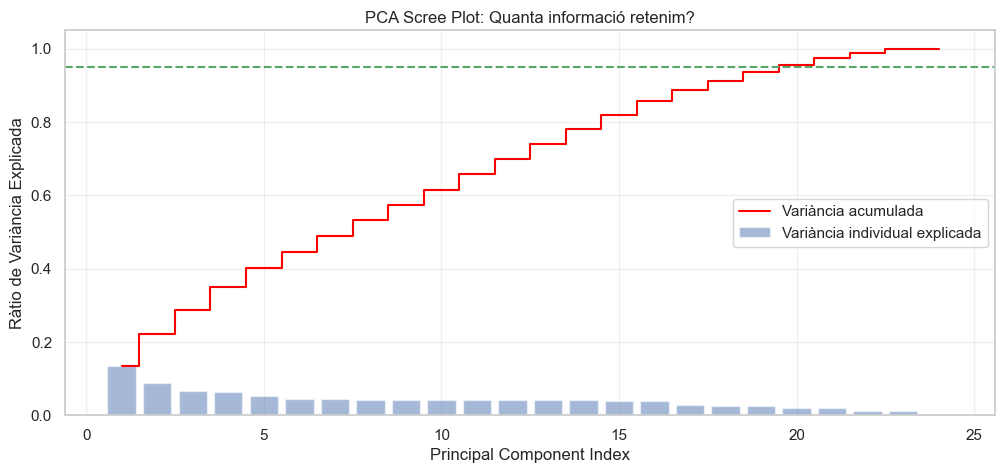

Necessites 20 components per explicar el 95% de la variància.
------------------------------------------------------------


In [ ]:
features = df.select_dtypes(include=['number']).columns.tolist()
if 'patient_id' in features: features.remove('patient_id')
if 'TRS' in features: features.remove('TRS')

X = df[features]


imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

# IMPORTANT: PCA requereix dades escalades (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. VISUALITZACIÓ (SCREE PLOT)
# -----------------------------
# Variància explicada per cada component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12, 5))

# Gràfic de barres (Variància individual)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Variància individual explicada')

# Gràfic de línia (Variància acumulada)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Variància acumulada', color='red')

plt.ylabel('Ràtio de Variància Explicada')
plt.xlabel('Principal Component Index')
plt.title('PCA Scree Plot: Quanta informació retenim?')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Línia de tall al 90% o 95%
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.show()

# Imprimir quants components calen per arribar al 95%
n_components90 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Necessites {n_components90} components per explicar el 95% de la variància.")
print("-" * 60)


Després d'aquest anàlisi, decidim:

- Per a SVM i Reg. Logística: No eliminem variables, sinó que entrenem amb PCA. També transformatem les variables numèriques per reduir skewness (Box-Cox o Yeo-Johnson segons correspongui).
- Per a XGBoost: No fem PCA, però eliminem variables molt correlacionades (correlació > 0.9) i variables amb skewness > 3 o < -3.


## 2. Preprocessament de dades per model

### 2.1 Per a SVM

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Carregar dades
df = pd.read_csv('trs_train.csv')

# Separar X i y
if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna objectiu 'TRS'")

# Eliminar ID si existeix
if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")


Dimensions inicials: (9000, 26)


1. Particionar

In [19]:
# Dividim 80% Train, 20% Test
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train SVM shape: {X_train_svm.shape}")
print(f"Test SVM shape:  {X_test_svm.shape}")


Train SVM shape: (7200, 26)
Test SVM shape:  (1800, 26)


2. Codificació de variables categòriques amb One-Hot Encoding

In [20]:
# Identifiquem columnes
cat_cols = X_train_svm.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_svm.select_dtypes(exclude=['object']).columns.tolist()

print(f"Variables categòriques: {cat_cols}")

# Inicialitzem l'encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Fit només en train
ohe.fit(X_train_svm[cat_cols])

# Transformem
X_train_cat_encoded = ohe.transform(X_train_svm[cat_cols])
X_test_cat_encoded = ohe.transform(X_test_svm[cat_cols])

# Convertim a DataFrame
new_cat_names = ohe.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=new_cat_names, index=X_train_svm.index)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=new_cat_names, index=X_test_svm.index)

# Reconstruïm els DataFrames (Numèriques + Categòriques codificades)
X_train_svm = pd.concat([X_train_svm[num_cols], X_train_cat_df], axis=1)
X_test_svm = pd.concat([X_test_svm[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després One-Hot: {X_train_svm.shape}")


Variables categòriques: ['Ethnicity', 'CYP2D6_metabolic_phenotype']
Dimensions després One-Hot: (7200, 30)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [21]:
# 1. Escalat Temporal per al KNN (imprescindible per distàncies)
scaler_temp = StandardScaler()
# Ajustem l'escalador temporal sobre les dades actuals
X_train_scaled_temp = scaler_temp.fit_transform(X_train_svm)
X_test_scaled_temp = scaler_temp.transform(X_test_svm)

# 2. Aplicar KNN Imputer
knn = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn.transform(X_test_scaled_temp)

# 3. Tornar a l'escala original (Inverse Transform) per poder aplicar Box-Cox després
X_train_svm = pd.DataFrame(scaler_temp.inverse_transform(X_train_imputed_vals), 
                           columns=X_train_svm.columns, index=X_train_svm.index)
X_test_svm = pd.DataFrame(scaler_temp.inverse_transform(X_test_imputed_vals), 
                          columns=X_test_svm.columns, index=X_test_svm.index)

print(f"Valors perduts restants: {X_train_svm.isnull().sum().sum()}")


Valors perduts restants: 0


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer (Box-Cox o Yeo-Johnson segons correspongui)

In [ ]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)

cols_skewed = ['Duration_untreated_psychosis', 'Age']

# Fit només en train
pt.fit(X_train_svm[cols_skewed])

# Transformem les columnes específiques
X_train_svm[cols_skewed] = pt.transform(X_train_svm[cols_skewed])
X_test_svm[cols_skewed] = pt.transform(X_test_svm[cols_skewed])

print("Transformació d'asimetria completada.")


Transformació d'asimetria completada.


5. Escalat de les variables numèriques amb StandardScaler

In [23]:
scaler_final = StandardScaler()

X_train_svm_final = scaler_final.fit_transform(X_train_svm)
X_test_svm_final = scaler_final.transform(X_test_svm)

print("Escalat final completat. Dades llestes per al model.")


Escalat final completat. Dades llestes per al model.


6. Entrenament del model SVM

In [34]:


#calculem proporció de la classe objectiu per definir pesos
class_counts = y_train_svm.value_counts()
print("Comptatge de classes en el conjunt d'entrenament:") 
print(class_counts)
print("\n" + "="*50 + "\n")

class_weights = {
    0: 1,
    1: class_counts[0] / class_counts[1]  # Pes inversament proporcional a la freqüència
}

param_grid = {
    'C': [0.001, 0.01, 0.1, 1], 
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'linear', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 2}, class_weights],
    'degree': [2, 3, 4]  
}
svm_base = SVC(class_weight='balanced', random_state=42)


grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

# 4. Executar el Grid Search (Fit sobre les dades entrenament processades)
print("Iniciant Grid Search per SVM...")
grid_search.fit(X_train_svm_final, y_train_svm)

# 5. Mostrar els millors resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_search.best_params_}")
print(f"MILLOR F1-SCORE (CV): {grid_search.best_score_:.4f}")
print("="*50 + "\n")

# 6. Avaluar el millor model sobre el Test Set
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_svm_final)

print("--- RESULTATS DEL MILLOR MODEL (TEST SET) ---")
print(classification_report(y_test_svm, y_pred_best))

# retornem el valor f1-score del millor model en el test set
f1 = f1_score(y_test_svm, y_pred_best, average='macro')
print(f"F1-Score del millor model en Test Set: {f1:.4f}")



Comptatge de classes en el conjunt d'entrenament:
TRS
0    4930
1    2270
Name: count, dtype: int64


Iniciant Grid Search per SVM...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

MILLORS PARÀMETRES: {'C': 0.1, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
MILLOR F1-SCORE (CV): 0.5895

--- RESULTATS DEL MILLOR MODEL (TEST SET) ---
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1232
           1       0.40      0.53      0.46       568

    accuracy                           0.60      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.64      0.60      0.62      1800

F1-Score del millor model en Test Set: 0.5729


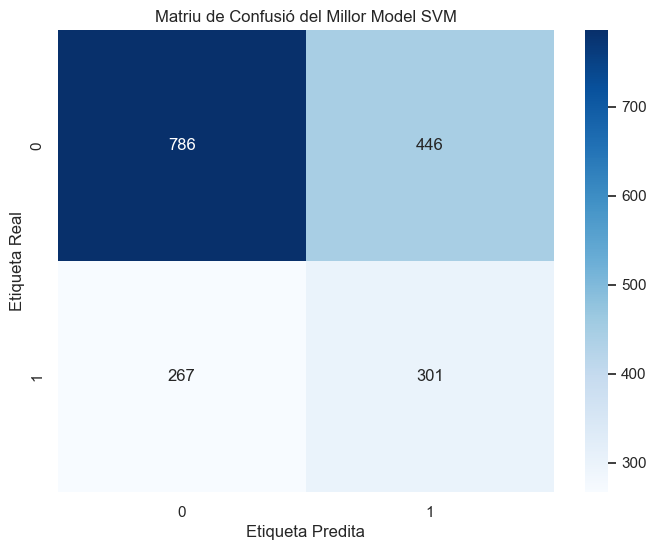

In [35]:
cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_svm.classes_, 
            yticklabels=best_svm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model SVM')
plt.show()

Per tal de generar una submission, haurem de preprocessar de la mateixa manera el dataset trs_eval.csv abans de fer les prediccions.

In [36]:
# ==============================================================================
# PREPROCESSING DEL DATASET D'AVALUACIÓ (trs_eval.csv)
# ==============================================================================

# 1. Carregar dades d'avaluació
df_eval = pd.read_csv('trs_eval.csv')

# Guardem els IDs per a l'arxiu de submissió final
eval_ids = df_eval['patient_id']

# Preparem X_eval (eliminem ID si hi és, igual que a train)
X_eval = df_eval.drop('patient_id', axis=1) if 'patient_id' in df_eval.columns else df_eval.copy()

print(f"Dimensions inicials eval: {X_eval.shape}")

# ------------------------------------------------------------------------------
# PAS 1: ONE-HOT ENCODING (Usem el 'ohe' ja entrenat)
# ------------------------------------------------------------------------------
# Separem numèriques i categòriques (els noms de columnes han de coincidir amb train)
cat_cols_eval = X_eval.select_dtypes(include=['object']).columns.tolist()
num_cols_eval = X_eval.select_dtypes(exclude=['object']).columns.tolist()

# Transformar (NO FIT)
X_eval_cat_encoded = ohe.transform(X_eval[cat_cols_eval])

# Convertir a DataFrame
X_eval_cat_df = pd.DataFrame(X_eval_cat_encoded, columns=new_cat_names, index=X_eval.index)

# Reconstruir DataFrame (numèriques + categòriques)
X_eval_step2 = pd.concat([X_eval[num_cols_eval], X_eval_cat_df], axis=1)

print(f"Dimensions després One-Hot: {X_eval_step2.shape}")

# ------------------------------------------------------------------------------
# PAS 2: IMPUTACIÓ KNN (Usem el 'scaler_temp' i 'knn' ja entrenats)
# ------------------------------------------------------------------------------
# 1. Escalar temporalment (usant la mitjana/std del train)
X_eval_scaled_temp = scaler_temp.transform(X_eval_step2)

# 2. Imputar (buscant veïns en el train, que estan guardats dins l'objecte knn)
X_eval_imputed_vals = knn.transform(X_eval_scaled_temp)

# 3. Des-escalar (tornar a unitats originals)
X_eval_step3 = pd.DataFrame(scaler_temp.inverse_transform(X_eval_imputed_vals), 
                            columns=X_eval_step2.columns, index=X_eval.index)

print(f"NaNs restants: {X_eval_step3.isnull().sum().sum()}")

# ------------------------------------------------------------------------------
# PAS 3: TRANSFORMACIÓ ASIMETRIA (Usem el 'pt' ja entrenat)
# ------------------------------------------------------------------------------
cols_skewed = ['Duration_untreated_psychosis', 'Age']
X_eval_step3[cols_skewed] = pt.transform(X_eval_step3[cols_skewed])

print("Transformació Box-Cox aplicada.")

# ------------------------------------------------------------------------------
# PAS 4: ESCALAT FINAL (Usem el 'scaler_final' ja entrenat)
# ------------------------------------------------------------------------------
X_eval_final = scaler_final.transform(X_eval_step3)

print("Escalat final aplicat.")

# ==============================================================================
# PREDICCIÓ I GENERACIÓ DE SUBMISSIÓ
# ==============================================================================

# Fer prediccions amb el millor model trobat
# (Assegura't que 'best_svm' o 'svm_model' és el teu model final entrenat)
final_predictions = best_svm.predict(X_eval_final) # o svm_model.predict()

# Crear DataFrame de submissió
submission = pd.DataFrame({
    'patient_id': eval_ids,
    'TRS': final_predictions
})

# Guardar a CSV
submission.to_csv('submission.csv', index=False)

print("\n" + "="*50)
print("✓ Arxiu 'submission.csv' creat correctament!")
print("Dimensions submissió:", submission.shape)
print("Distribució prediccions:")
print(submission['TRS'].value_counts())
print("="*50)


Dimensions inicials eval: (1000, 26)
Dimensions després One-Hot: (1000, 30)
NaNs restants: 0
Transformació Box-Cox aplicada.
Escalat final aplicat.

✓ Arxiu 'submission.csv' creat correctament!
Dimensions submissió: (1000, 2)
Distribució prediccions:
TRS
0    629
1    371
Name: count, dtype: int64


Provem a ajustar el model SVM a partir dels components principals (PCA) per veure si millora el rendiment. Aprofiem els 4 primers passos ja fets en el preprocessament per a SVM i afegim:

In [37]:
# Triem n_components=0.95 (mantenir el 95% de la variància explicada)
# O pots posar un enter, ex: n_components=10
pca = PCA(n_components=0.95, random_state=42)

# Fit només en Train
X_train_pca = pca.fit_transform(X_train_svm_final)
# Transform en Test
X_test_pca = pca.transform(X_test_svm_final)

print(f"Dimensions originals: {X_train_svm_final.shape}")
print(f"Dimensions després PCA: {X_train_pca.shape}")
print(f"Nombre de components retinguts: {pca.n_components_}")

Dimensions originals: (7200, 30)
Dimensions després PCA: (7200, 25)
Nombre de components retinguts: 25


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 1. Definir la Pipeline (Seqüència d'operacions)
# Pas 1: PCA
# Pas 2: SVM
pipe_pca_svm = Pipeline([
    ('pca', PCA(random_state=42)),
    ('svm', SVC(class_weight='balanced', random_state=42))
])

#calculem proporció de la classe objectiu per definir pesos
class_counts = y_train_svm.value_counts()
print("Comptatge de classes en el conjunt d'entrenament:")
print(class_counts)

class_weights = {
    0: 1,
    1: class_counts[0] / class_counts[1]  # Pes inversament proporcional a la freqüència
}

# 2. Definir la graella de paràmetres (Param Grid)
# IMPORTANT: Posem el nom del pas seguit de doble guió baix __
param_grid = {
    # PARÀMETRES DEL PCA
    # Provem mantenir diferents % de variància o número fix de components
    'pca__n_components': [ 0.99], 
    
    # PARÀMETRES DEL SVM
    'svm__C': [0.01, 0.1],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'poly'],
    'svm__degree': [2, 3, 4],  # Només per a kernel 'poly'
    'svm__class_weight': ['balanced', {0: 1, 1: 2}, class_weights,]  # Prova amb pesos diferents per a les classes
}

# 3. Configurar el Grid Search
grid_pca = GridSearchCV(
    estimator=pipe_pca_svm,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro', # Optimitzem F1-score (millor per desbalanceig)
    verbose=2,
    n_jobs=-1
)

# 4. Executar (Fit)
# Passem les dades ESCALADES (PCA requereix escalat previ)
print("Iniciant Grid Search (PCA + SVM)...")
grid_pca.fit(X_train_svm_final, y_train_svm)

# 5. Resultats
print("\n" + "="*50)
print(f"MILLOR COMBINACIÓ: {grid_pca.best_params_}")
print(f"MILLOR SCORE (CV): {grid_pca.best_score_:.4f}")
print("="*50)

# 6. Avaluar al Test Set
# La pipeline s'encarrega automàticament de fer pca.transform() i svm.predict()
best_model = grid_pca.best_estimator_
y_pred_pca = best_model.predict(X_test_svm_final)

print("\n--- RESULTATS FINALS (TEST SET) ---")
print(classification_report(y_test_svm, y_pred_pca))


Comptatge de classes en el conjunt d'entrenament:
TRS
0    4930
1    2270
Name: count, dtype: int64
Iniciant Grid Search (PCA + SVM)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

MILLOR COMBINACIÓ: {'pca__n_components': 0.99, 'svm__C': 0.1, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
MILLOR SCORE (CV): 0.5901

--- RESULTATS FINALS (TEST SET) ---
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1232
           1       0.40      0.53      0.46       568

    accuracy                           0.60      1800
   macro avg       0.58      0.58      0.57      1800
weighted avg       0.64      0.60      0.62      1800



F1-Score del millor model PCA+SVM en Test Set: 0.5736


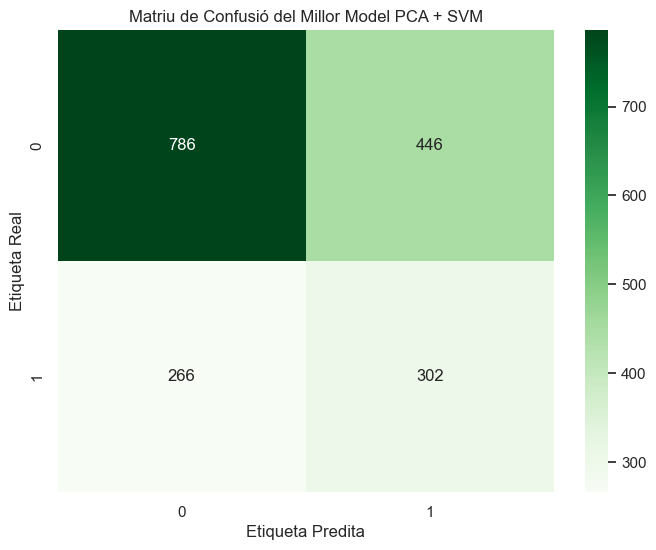

In [41]:
f1_pca = f1_score(y_test_svm, y_pred_pca, average='macro')
print(f"F1-Score del millor model PCA+SVM en Test Set: {f1_pca:.4f}")

# Matriu de confusió
cm_pca = confusion_matrix(y_test_svm, y_pred_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', 
            xticklabels=best_model.named_steps['svm'].classes_, 
            yticklabels=best_model.named_steps['svm'].classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model PCA + SVM')
plt.show()


In [ ]:

final_predictions_pca = best_model.predict(X_eval_final)

# (La resta igual)
submission_pca = pd.DataFrame({
    'patient_id': eval_ids,
    'TRS': final_predictions_pca
})
submission_pca.to_csv('submission_pca_svm.csv', index=False)


## 2.2 Per a XGBoost

1. Particionar

In [44]:
df = pd.read_csv('trs_train.csv')

if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna TRS")

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train XGB shape: {X_train_xgb.shape}")

Dimensions inicials: (9000, 26)
Train XGB shape: (7200, 26)


També eliminem les variables molt correlacionades (correlació > 0.9) i les variables amb skewness > 3 o < -3, que són:



2. Codificació de variables categòriques amb One-Hot Encoding

In [45]:
cat_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

# Inicialitzem Encoder (IMPORTANT: sparse_output=False per tenir matriu densa)
ohe_xgb = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Fit en Train
ohe_xgb.fit(X_train_xgb[cat_cols])

# Transform
X_train_cat = ohe_xgb.transform(X_train_xgb[cat_cols])
X_test_cat = ohe_xgb.transform(X_test_xgb[cat_cols])

# Convertir a DataFrame
new_names = ohe_xgb.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_xgb.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_xgb.index)

# Reconstruir (Numèriques + Categòriques)
X_train_xgb = pd.concat([X_train_xgb[num_cols], X_train_cat_df], axis=1)
X_test_xgb = pd.concat([X_test_xgb[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després encoding: {X_train_xgb.shape}")


Dimensions després encoding: (7200, 30)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [46]:
from sklearn.preprocessing import StandardScaler
scaler_temp_xgb = StandardScaler()

X_train_scaled_temp = scaler_temp_xgb.fit_transform(X_train_xgb)
X_test_scaled_temp = scaler_temp_xgb.transform(X_test_xgb)

knn_xgb = KNNImputer(n_neighbors=5)

X_train_imputed = knn_xgb.fit_transform(X_train_scaled_temp)
X_test_imputed = knn_xgb.transform(X_test_scaled_temp)

# TORNAR A L'ESCALA ORIGINAL (MOLT IMPORTANT PER A XGBOOST)
# XGBoost prefereix els valors reals (anys, glucosa mg/dL...) per fer talls llegibles
X_train_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_train_imputed), 
                           columns=X_train_xgb.columns, index=X_train_xgb.index)
X_test_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_test_imputed), 
                          columns=X_test_xgb.columns, index=X_test_xgb.index)

print(f"Valors perduts restants: {X_train_xgb.isnull().sum().sum()}")

Valors perduts restants: 0


4. Entrenament del model XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 1. Calcular el ratio per al desbalanceig (com abans)
ratio_xgb = float(np.sum(y_train_xgb == 0)) / np.sum(y_train_xgb == 1)
print(f"Ratio calculat per scale_pos_weight: {ratio_xgb:.2f}")

# 2. Definir el model base
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Definir la graella de paràmetres
param_grid_xgb = {
    # Profunditat de l'arbre: Valors típics entre 3 i 10
    'max_depth': [5],
    
    # Velocitat d'aprenentatge: Menys és més precís, però requereix més arbres
    'learning_rate': [0.0001, 0.001,0.01],
    
    # Nombre d'arbres:
    'n_estimators':  [1000],
    
    # Gestió desbalanceig:
    # 1.0 = per defecte
    # ratio_xgb = equilibrat matemàticament
    # ratio_xgb * 1.5 = donar encara més prioritat a trobar els casos positius
    'scale_pos_weight': [1, ratio_xgb, ratio_xgb * 1.5],
    
    # Regularització (per evitar overfitting)
    # subsample: % de dades usades per arbre (0.8 sol anar molt bé)
    'subsample': [0.8],
    'colsample_bytree': [0.8],
 
}

# 4. Configurar el Grid Search
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=5,                 # 5-Fold Cross Validation
    scoring='f1_macro',   # O 'roc_auc' si prefereixes
    verbose=1,
    n_jobs=-1             # Paral·lelització total
)

# 5. Entrenar
print("Iniciant Grid Search per XGBoost...")
grid_xgb.fit(X_train_xgb, y_train_xgb)

# 6. Resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_xgb.best_params_}")
print(f"MILLOR SCORE (CV): {grid_xgb.best_score_:.4f}")
print("="*50)

# 7. Avaluar al Test Set
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test_xgb)

print("\n--- RESULTATS MILLOR XGBOOST (TEST SET) ---")
print(classification_report(y_test_xgb, y_pred_best_xgb))


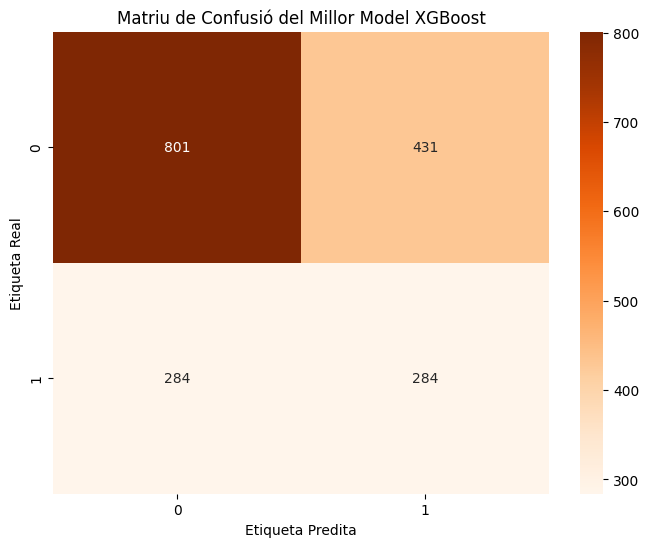

F1-Score del millor model XGBoost en Test Set: 0.5671
Dimensions inicials eval XGB: (1000, 26)
Dimensions després One-Hot XGB: (1000, 30)
NaNs restants XGB: 0


In [54]:
# veiem la matriu de confusió
cm_xgb = confusion_matrix(y_test_xgb, y_pred_best_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=best_xgb.classes_, 
            yticklabels=best_xgb.classes_)  
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model XGBoost')
plt.show()
f1_xgb = f1_score(y_test_xgb, y_pred_best_xgb, average='macro')
print(f"F1-Score del millor model XGBoost en Test Set: {f1_xgb:.4f}")

# PREDICCIÓ SOBRE EL DATASET D'AVALUACIÓ (trs_eval.csv)
df_eval_xgb = pd.read_csv('trs_eval.csv')
eval_ids_xgb = df_eval_xgb['patient_id']
X_eval_xgb = df_eval_xgb.drop('patient_id', axis=1) if 'patient_id' in df_eval_xgb.columns else df_eval_xgb.copy()
print(f"Dimensions inicials eval XGB: {X_eval_xgb.shape}")
# One-Hot Encoding
cat_cols_eval_xgb = X_eval_xgb.select_dtypes(include=['object']).columns.tolist()
num_cols_eval_xgb = X_eval_xgb.select_dtypes(exclude=['object']).columns.tolist()
X_eval_cat_xgb = ohe_xgb.transform(X_eval_xgb[cat_cols_eval_xgb])
X_eval_cat_df_xgb = pd.DataFrame(X_eval_cat_xgb, columns=new_names, index=X_eval_xgb.index)
X_eval_step2_xgb = pd.concat([X_eval_xgb[num_cols_eval_xgb], X_eval_cat_df_xgb], axis=1)
print(f"Dimensions després One-Hot XGB: {X_eval_step2_xgb.shape}")
# Imputació KNN
X_eval_scaled_temp_xgb = scaler_temp_xgb.transform(X_eval_step2_xgb)
X_eval_imputed_xgb = knn_xgb.transform(X_eval_scaled_temp_xgb)
X_eval_step3_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_eval_imputed_xgb), 
                            columns=X_eval_step2_xgb.columns, index=X_eval_step2_xgb.index)
print(f"NaNs restants XGB: {X_eval_step3_xgb.isnull().sum().sum()}")
# Prediccions
final_predictions_xgb = best_xgb.predict(X_eval_step3_xgb)
submission_xgb = pd.DataFrame({
    'patient_id': eval_ids_xgb,
    'TRS': final_predictions_xgb
})
submission_xgb.to_csv('submission_xgb.csv', index=False)



## 2.3 Per a Regressió Logística personalitzada

1. Particionar


In [28]:
df = pd.read_csv('trs_train.csv')

if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna TRS")

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train LogReg shape: {X_train_lr.shape}")

Dimensions inicials: (9000, 26)
Train LogReg shape: (7200, 26)


També eliminem les variables molt correlacionades (correlació > 0.4):

In [29]:
#eliminem les variables correlacionades

#agafem les variables numèriques no binàries ni categòriques codificades
num_cols_lr = X_train_lr.select_dtypes(include=['number']).columns.tolist()
num_cols_lr = [col for col in num_cols_lr if X_train_lr[col].nunique() > 10]
#creem una matriu de correlació i eliminem les variables amb correlació > 0.7
corr_matrix_lr = X_train_lr[num_cols_lr].corr().abs()
upper_tri = corr_matrix_lr.where(np.triu(np.ones(corr_matrix_lr.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
X_train_lr = X_train_lr.drop(columns=to_drop)
X_test_lr = X_test_lr.drop(columns=to_drop)
print(f"Dimensions després d'eliminar variables correlacionades: {X_train_lr.shape}")


Dimensions després d'eliminar variables correlacionades: (7200, 23)


2. Codificació de variables categòriques amb One-Hot Encoding

In [30]:
# PAS 2 (REAL): One-Hot Encoding
cat_cols = X_train_lr.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_lr.select_dtypes(exclude=['object']).columns.tolist()

ohe_lr = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohe_lr.fit(X_train_lr[cat_cols])

# Transformem
X_train_cat = ohe_lr.transform(X_train_lr[cat_cols])
X_test_cat = ohe_lr.transform(X_test_lr[cat_cols])

# Convertir a DataFrame
new_names = ohe_lr.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_lr.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_lr.index)

# Reconstruir
X_train_lr = pd.concat([X_train_lr[num_cols], X_train_cat_df], axis=1)
X_test_lr = pd.concat([X_test_lr[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després Encoding: {X_train_lr.shape}")

Dimensions després Encoding: (7200, 27)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [31]:
scaler_temp_lr = StandardScaler()
X_train_scaled_temp = scaler_temp_lr.fit_transform(X_train_lr)
X_test_scaled_temp = scaler_temp_lr.transform(X_test_lr)

knn_lr = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn_lr.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn_lr.transform(X_test_scaled_temp)

# Tornem a l'escala original per poder fer Box-Cox
X_train_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_train_imputed_vals), 
                          columns=X_train_lr.columns, index=X_train_lr.index)
X_test_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_test_imputed_vals), 
                         columns=X_test_lr.columns, index=X_test_lr.index)

print(f"Valors perduts restants: {X_train_lr.isnull().sum().sum()}")

Valors perduts restants: 0


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer (Box-Cox o Yeo-Johnson segons correspongui)

In [32]:
from sklearn.preprocessing import PowerTransformer

pt_lr = PowerTransformer(method='yeo-johnson', standardize=False)
cols_skewed = ['Duration_untreated_psychosis', 'Age']

pt_lr.fit(X_train_lr[cols_skewed])

X_train_lr[cols_skewed] = pt_lr.transform(X_train_lr[cols_skewed])
X_test_lr[cols_skewed] = pt_lr.transform(X_test_lr[cols_skewed])

print("Transformació Yeo-Johnson aplicada.")

Transformació Yeo-Johnson aplicada.


5. Escalat de les variables numèriques amb StandardScaler

In [34]:
scaler_final_lr = StandardScaler()

X_train_lr_final = scaler_final_lr.fit_transform(X_train_lr)
X_test_lr_final = scaler_final_lr.transform(X_test_lr)

print("Escalat final completat.")

Escalat final completat.


6. Model de Regressió Logística personalitzada 

In [43]:
import numpy as np

class CustomLogisticRegression:
    """
    Regressió Logística amb Descens de Gradient per Minibatch.
    Estil scikit-learn amb mètodes fit(), predict(), predict_proba().
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32, 
                 regularization='l2', lambda_reg=0.01, class_weight=None, 
                 random_state=None, verbose=False):
        """
        Paràmetres:
        -----------
        learning_rate : float
            Taxa d'aprenentatge per al descens de gradient.
        n_iterations : int
            Nombre d'èpoques (passades completes pel dataset).
        batch_size : int
            Mida del minibatch per al descens de gradient.
        regularization : str ('l1', 'l2', None)
            Tipus de regularització.
        lambda_reg : float
            Força de la regularització.
        class_weight : dict o 'balanced'
            Pesos per a les classes (per gestionar desbalanceig).
        random_state : int
            Llavor per a reproducibilitat.
        verbose : bool
            Si True, mostra el progrés durant l'entrenament.
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.class_weight = class_weight
        self.random_state = random_state
        self.verbose = verbose
        
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.classes_ = None
        
    def _sigmoid(self, z):
        """Funció sigmoide amb clip per evitar overflow."""
        z = np.clip(z, -500, 500)  # Evitar overflow
        return 1 / (1 + np.exp(-z))
    
    def _compute_loss(self, y_true, y_pred, sample_weights=None):
        """
        Calcula la funció de pèrdua (Binary Cross-Entropy) amb regularització.
        """
        # Evitar log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Binary Cross-Entropy
        if sample_weights is not None:
            bce = -np.mean(sample_weights * (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
        else:
            bce = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # Afegir regularització
        if self.regularization == 'l2':
            reg_term = (self.lambda_reg / 2) * np.sum(self.weights ** 2)
        elif self.regularization == 'l1':
            reg_term = self.lambda_reg * np.sum(np.abs(self.weights))
        else:
            reg_term = 0
            
        return bce + reg_term
    
    def _compute_gradients(self, X, y_true, y_pred, sample_weights=None):
        """
        Calcula els gradients dels pesos i el biaix.
        """
        n_samples = X.shape[0]
        
        # Error
        error = y_pred - y_true
        
        # Aplicar pesos de mostra si existeixen
        if sample_weights is not None:
            error = error * sample_weights
        
        # Gradient dels pesos
        dw = (1 / n_samples) * np.dot(X.T, error)
        
        # Afegir gradient de regularització
        if self.regularization == 'l2':
            dw += self.lambda_reg * self.weights
        elif self.regularization == 'l1':
            dw += self.lambda_reg * np.sign(self.weights)
        
        # Gradient del biaix
        db = (1 / n_samples) * np.sum(error)
        
        return dw, db
    
    def _get_sample_weights(self, y):
        """
        Calcula els pesos de cada mostra segons la classe.
        """
        if self.class_weight is None:
            return None
        
        sample_weights = np.ones(len(y))
        
        if self.class_weight == 'balanced':
            # Calcular pesos inversament proporcionals a la freqüència
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            weights = n_samples / (n_classes * counts)
            weight_dict = dict(zip(classes, weights))
        else:
            weight_dict = self.class_weight
        
        for cls, weight in weight_dict.items():
            sample_weights[y == cls] = weight
            
        return sample_weights
    
    def fit(self, X, y):
        """
        Entrena el model de regressió logística amb minibatch gradient descent.
        
        Paràmetres:
        -----------
        X : array-like, shape (n_samples, n_features)
            Dades d'entrenament.
        y : array-like, shape (n_samples,)
            Etiquetes objectiu.
            
        Returns:
        --------
        self : objecte
            Retorna l'instància entrenada.
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Convertir a numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        n_samples, n_features = X.shape
        
        # Guardar classes
        self.classes_ = np.unique(y)
        
        # Inicialitzar pesos amb Xavier initialization
        self.weights = np.random.randn(n_features) * np.sqrt(2 / n_features)
        self.bias = 0.0
        
        # Obtenir pesos de mostra
        sample_weights = self._get_sample_weights(y)
        
        # Descens de gradient per minibatch
        self.loss_history = []
        
        for epoch in range(self.n_iterations):
            # Barrejar les dades a cada època
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            if sample_weights is not None:
                sw_shuffled = sample_weights[indices]
            else:
                sw_shuffled = None
            
            epoch_loss = 0
            n_batches = 0
            
            # Iterar per minibatches
            for i in range(0, n_samples, self.batch_size):
                # Obtenir minibatch
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                if sw_shuffled is not None:
                    sw_batch = sw_shuffled[i:i + self.batch_size]
                else:
                    sw_batch = None
                
                # Forward pass
                z = np.dot(X_batch, self.weights) + self.bias
                y_pred = self._sigmoid(z)
                
                # Calcular pèrdua del batch
                batch_loss = self._compute_loss(y_batch, y_pred, sw_batch)
                epoch_loss += batch_loss
                n_batches += 1
                
                # Backward pass - calcular gradients
                dw, db = self._compute_gradients(X_batch, y_batch, y_pred, sw_batch)
                
                # Actualitzar paràmetres
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            # Pèrdua mitjana de l'època
            avg_loss = epoch_loss / n_batches
            self.loss_history.append(avg_loss)
            
            # Mostrar progrés
            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Època {epoch + 1}/{self.n_iterations} - Loss: {avg_loss:.6f}")
        
        return self
    
    def predict_proba(self, X):
        """
        Retorna les probabilitats predites per cada classe.
        
        Paràmetres:
        -----------
        X : array-like, shape (n_samples, n_features)
            Dades a predir.
            
        Returns:
        --------
        proba : array, shape (n_samples, 2)
            Probabilitats per a cada classe [P(y=0), P(y=1)].
        """
        X = np.array(X)
        z = np.dot(X, self.weights) + self.bias
        prob_1 = self._sigmoid(z)
        prob_0 = 1 - prob_1
        return np.column_stack([prob_0, prob_1])
    
    def predict(self, X, threshold=0.5):
        """
        Retorna les prediccions binàries.
        
        Paràmetres:
        -----------
        X : array-like, shape (n_samples, n_features)
            Dades a predir.
        threshold : float
            Llindar de decisió (per defecte 0.5).
            
        Returns:
        --------
        predictions : array, shape (n_samples,)
            Prediccions binàries (0 o 1).
        """
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)
    
    def score(self, X, y):
        """
        Retorna l'accuracy del model.
        """
        predictions = self.predict(X)
        return np.mean(predictions == y)
    
    def get_params(self, deep=True):
        """Retorna els paràmetres del model (compatibilitat scikit-learn)."""
        return {
            'learning_rate': self.learning_rate,
            'n_iterations': self.n_iterations,
            'batch_size': self.batch_size,
            'regularization': self.regularization,
            'lambda_reg': self.lambda_reg,
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'verbose': self.verbose
        }
    
    def set_params(self, **params):
        """Estableix els paràmetres del model (compatibilitat scikit-learn)."""
        for key, value in params.items():
            setattr(self, key, value)
        return self


# =====================================================================
# ENTRENAMENT DEL MODEL
# =====================================================================

print("=" * 60)
print("ENTRENAMENT DE LA REGRESSIÓ LOGÍSTICA PERSONALITZADA")
print("=" * 60)

# Calcular pesos de classe per al desbalanceig
class_counts = y_train_lr.value_counts()
print(f"\nDistribució de classes:")
print(class_counts)

# Crear model amb pesos balancejats
model_lr = CustomLogisticRegression(
    learning_rate=0.01,
    n_iterations=1000,
    batch_size=32,
    regularization='l2',
    lambda_reg=0.01,
    class_weight='balanced',
    random_state=42,
    verbose=True
)

# Entrenar
print("\nEntrenant el model...")
model_lr.fit(X_train_lr_final, y_train_lr.values)

# Prediccions
y_pred_lr = model_lr.predict(X_test_lr_final)

# Resultats
print("\n" + "=" * 60)
print("RESULTATS (TEST SET)")
print("=" * 60)
print(classification_report(y_test_lr, y_pred_lr))

f1_lr = f1_score(y_test_lr, y_pred_lr, average='macro')
print(f"F1-Score Macro: {f1_lr:.4f}")

ENTRENAMENT DE LA REGRESSIÓ LOGÍSTICA PERSONALITZADA

Distribució de classes:
TRS
0    4930
1    2270
Name: count, dtype: int64

Entrenant el model...
Època 100/1000 - Loss: 0.658230
Època 200/1000 - Loss: 0.658228
Època 300/1000 - Loss: 0.658293
Època 400/1000 - Loss: 0.658215
Època 500/1000 - Loss: 0.658290
Època 600/1000 - Loss: 0.658213
Època 700/1000 - Loss: 0.658246
Època 800/1000 - Loss: 0.658230
Època 900/1000 - Loss: 0.658234
Època 1000/1000 - Loss: 0.658200

RESULTATS (TEST SET)
              precision    recall  f1-score   support

           0       0.76      0.57      0.65      1232
           1       0.39      0.61      0.48       568

    accuracy                           0.58      1800
   macro avg       0.58      0.59      0.57      1800
weighted avg       0.64      0.58      0.60      1800

F1-Score Macro: 0.5650


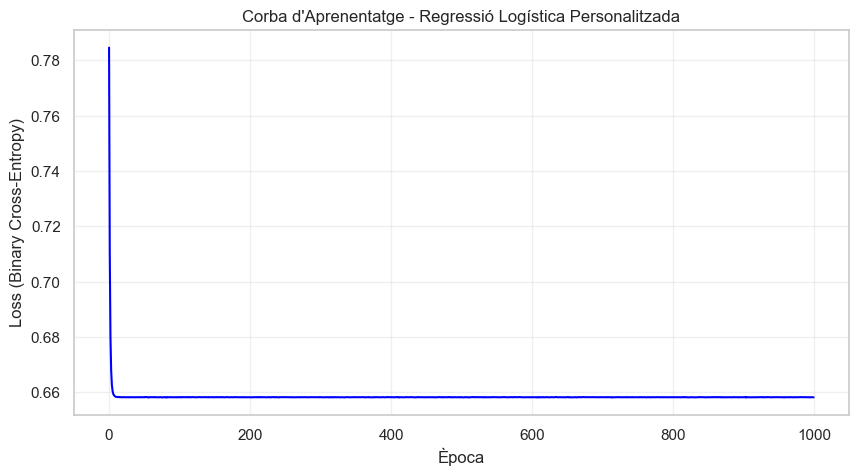

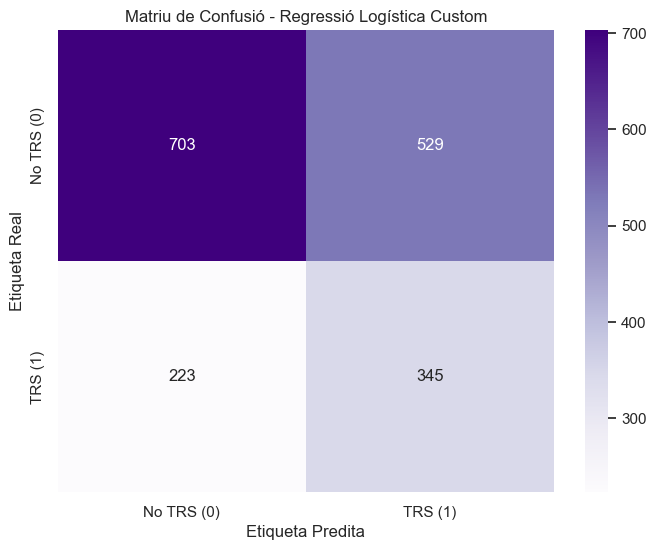


Recall classe 1 (TRS): 0.6074


In [44]:
# Visualització de la corba de pèrdua durant l'entrenament
plt.figure(figsize=(10, 5))
plt.plot(model_lr.loss_history, color='blue', linewidth=1.5)
plt.xlabel('Època')
plt.ylabel('Loss (Binary Cross-Entropy)')
plt.title('Corba d\'Aprenentatge - Regressió Logística Personalitzada')
plt.grid(True, alpha=0.3)
plt.show()

# Matriu de confusió
cm_lr = confusion_matrix(y_test_lr, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No TRS (0)', 'TRS (1)'], 
            yticklabels=['No TRS (0)', 'TRS (1)'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió - Regressió Logística Custom')
plt.show()

print(f"\nRecall classe 1 (TRS): {recall_score(y_test_lr, y_pred_lr):.4f}")

### Grid Search manual per optimitzar hiperparàmetres

In [45]:
from sklearn.model_selection import StratifiedKFold
from itertools import product

# =====================================================================
# GRID SEARCH MANUAL AMB CROSS-VALIDATION
# =====================================================================

# Definir graella de paràmetres
param_grid_lr = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_iterations': [500, 1000],
    'batch_size': [16, 32, 64],
    'lambda_reg': [0.001, 0.01, 0.1],
    'regularization': ['l2']
}

# Generar totes les combinacions
keys = param_grid_lr.keys()
combinations = list(product(*param_grid_lr.values()))

print(f"Total de combinacions a provar: {len(combinations)}")
print("=" * 60)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = 0
best_params = None
results = []

for i, combo in enumerate(combinations):
    params = dict(zip(keys, combo))
    
    fold_scores = []
    
    for train_idx, val_idx in cv.split(X_train_lr_final, y_train_lr):
        # Obtenir folds
        X_fold_train = X_train_lr_final[train_idx]
        y_fold_train = y_train_lr.values[train_idx]
        X_fold_val = X_train_lr_final[val_idx]
        y_fold_val = y_train_lr.values[val_idx]
        
        # Crear i entrenar model
        model = CustomLogisticRegression(
            learning_rate=params['learning_rate'],
            n_iterations=params['n_iterations'],
            batch_size=params['batch_size'],
            regularization=params['regularization'],
            lambda_reg=params['lambda_reg'],
            class_weight='balanced',
            random_state=42,
            verbose=False
        )
        model.fit(X_fold_train, y_fold_train)
        
        # Avaluar
        y_pred_fold = model.predict(X_fold_val)
        fold_f1 = f1_score(y_fold_val, y_pred_fold, average='macro')
        fold_scores.append(fold_f1)
    
    # Mitjana dels folds
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    
    results.append({
        'params': params,
        'mean_f1': mean_score,
        'std_f1': std_score
    })
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
    
    if (i + 1) % 10 == 0:
        print(f"Progrés: {i + 1}/{len(combinations)} combinacions avaluades...")

print("\n" + "=" * 60)
print(f"MILLORS PARÀMETRES TROBATS:")
print(f"  {best_params}")
print(f"MILLOR F1-SCORE (CV): {best_score:.4f}")
print("=" * 60)

Total de combinacions a provar: 54
Progrés: 10/54 combinacions avaluades...
Progrés: 20/54 combinacions avaluades...
Progrés: 30/54 combinacions avaluades...
Progrés: 40/54 combinacions avaluades...
Progrés: 50/54 combinacions avaluades...

MILLORS PARÀMETRES TROBATS:
  {'learning_rate': 0.01, 'n_iterations': 500, 'batch_size': 16, 'lambda_reg': 0.1, 'regularization': 'l2'}
MILLOR F1-SCORE (CV): 0.5814


Entrenant model final amb els millors paràmetres...
Època 100/500 - Loss: 0.667866
Època 200/500 - Loss: 0.667865
Època 300/500 - Loss: 0.667996
Època 400/500 - Loss: 0.667944
Època 500/500 - Loss: 0.668012

RESULTATS FINALS (TEST SET)
              precision    recall  f1-score   support

           0       0.76      0.57      0.65      1232
           1       0.39      0.61      0.48       568

    accuracy                           0.58      1800
   macro avg       0.58      0.59      0.56      1800
weighted avg       0.64      0.58      0.60      1800

F1-Score Macro: 0.5647


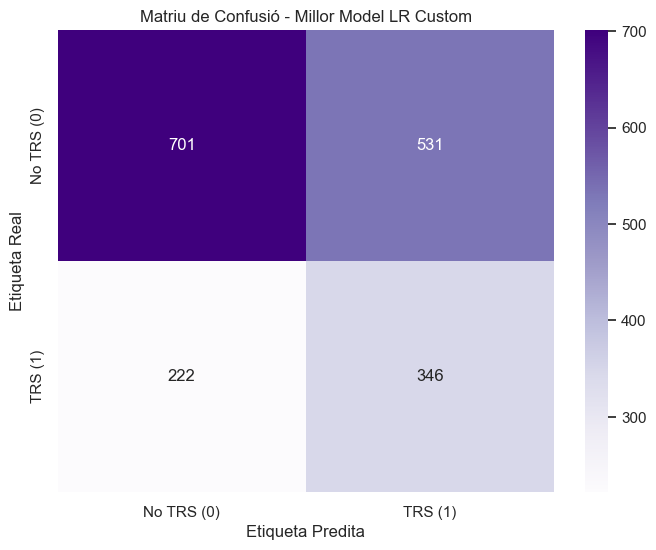

In [47]:
# =====================================================================
# ENTRENAR MODEL FINAL AMB ELS MILLORS PARÀMETRES
# =====================================================================

best_lr_model = CustomLogisticRegression(
    learning_rate=best_params['learning_rate'],
    n_iterations=best_params['n_iterations'],
    batch_size=best_params['batch_size'],
    regularization=best_params['regularization'],
    lambda_reg=best_params['lambda_reg'],
    class_weight='balanced',
    random_state=42,
    verbose=True
)

print("Entrenant model final amb els millors paràmetres...")
best_lr_model.fit(X_train_lr_final, y_train_lr.values)

# Prediccions finals
y_pred_best_lr = best_lr_model.predict(X_test_lr_final)

print("\n" + "=" * 60)
print("RESULTATS FINALS (TEST SET)")
print("=" * 60)
print(classification_report(y_test_lr, y_pred_best_lr))

f1_best_lr = f1_score(y_test_lr, y_pred_best_lr, average='macro')
print(f"F1-Score Macro: {f1_best_lr:.4f}")

# Matriu de confusió final
cm_best_lr = confusion_matrix(y_test_lr, y_pred_best_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_lr, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No TRS (0)', 'TRS (1)'], 
            yticklabels=['No TRS (0)', 'TRS (1)'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió - Millor Model LR Custom')
plt.show()

### Generació de la submissió amb el model de Regressió Logística Custom

In [ ]:
# =====================================================================
# PREPROCESSING DEL DATASET D'AVALUACIÓ PER A LOGREG CUSTOM
# =====================================================================

# 1. Carregar dades d'avaluació
df_eval_lr = pd.read_csv('trs_eval.csv')
eval_ids_lr = df_eval_lr['patient_id']

X_eval_lr = df_eval_lr.drop('patient_id', axis=1) if 'patient_id' in df_eval_lr.columns else df_eval_lr.copy()
print(f"Dimensions inicials eval: {X_eval_lr.shape}")

# PAS 1: Eliminar les mateixes columnes correlacionades que hem eliminat al train
X_eval_lr = X_eval_lr.drop(columns=to_drop, errors='ignore')
print(f"Dimensions després eliminar correlacionades: {X_eval_lr.shape}")

# PAS 2: One-Hot Encoding (usem ohe_lr ja entrenat)
cat_cols_eval_lr = X_eval_lr.select_dtypes(include=['object']).columns.tolist()
num_cols_eval_lr = X_eval_lr.select_dtypes(exclude=['object']).columns.tolist()

X_eval_cat_lr = ohe_lr.transform(X_eval_lr[cat_cols_eval_lr])
X_eval_cat_df_lr = pd.DataFrame(X_eval_cat_lr, columns=new_names, index=X_eval_lr.index)

X_eval_step2_lr = pd.concat([X_eval_lr[num_cols_eval_lr], X_eval_cat_df_lr], axis=1)
print(f"Dimensions després One-Hot: {X_eval_step2_lr.shape}")

# PAS 3: Imputació KNN (usem scaler_temp_lr i knn_lr)
X_eval_scaled_temp_lr = scaler_temp_lr.transform(X_eval_step2_lr)
X_eval_imputed_lr = knn_lr.transform(X_eval_scaled_temp_lr)
X_eval_step3_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_eval_imputed_lr), 
                               columns=X_eval_step2_lr.columns, index=X_eval_step2_lr.index)
print(f"NaNs restants: {X_eval_step3_lr.isnull().sum().sum()}")

# PAS 4: Transformació Yeo-Johnson (usem pt_lr)
cols_skewed = ['Duration_untreated_psychosis', 'Age']
X_eval_step3_lr[cols_skewed] = pt_lr.transform(X_eval_step3_lr[cols_skewed])
print("Transformació Yeo-Johnson aplicada.")

# PAS 5: Escalat final (usem scaler_final_lr)
X_eval_final_lr = scaler_final_lr.transform(X_eval_step3_lr)
print("Escalat final aplicat.")

# =====================================================================
# PREDICCIÓ I GENERACIÓ DE SUBMISSIÓ
# =====================================================================

final_predictions_lr = best_lr_model.predict(X_eval_final_lr)

submission_lr = pd.DataFrame({
    'patient_id': eval_ids_lr,
    'TRS': final_predictions_lr
})

submission_lr.to_csv('submission_logreg_custom.csv', index=False)

print("\n" + "=" * 60)
print("✓ Arxiu 'submission_logreg_custom.csv' creat correctament!")
print(f"Dimensions submissió: {submission_lr.shape}")
print("Distribució prediccions:")
print(submission_lr['TRS'].value_counts())
print("=" * 60)